In [36]:
#importing necessary libraries
%matplotlib inline
import numpy as np
from sympy.interactive import printing
printing.init_printing(use_latex=True)
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import tensorflow as tf


<ipython-input-36-23a243547156>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [37]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-s6fcckeo
  Running command git clone --filter=blob:none --quiet https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-s6fcckeo
  Resolved https://github.com/titu1994/tfdiffeq.git to commit ef646f85cbd0821749a03e7ab51e03e16798fab1
  Preparing metadata (setup.py) ... done


In [38]:
n= 100 #Number of points
device = 'cpu:0' # These experiments do not require the GPU. Normally, 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' should be used.
from tfdiffeq import odeint  #importing odeint function for solving ordinary differential equations from tensorflow
from tfdiffeq import plot_results #importing a plot function from tensorflow

In [39]:
#converting initial conditions to tensor objects
initial_states = tf.convert_to_tensor([1., 1.], dtype=tf.float64)
initial_states

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>

In [40]:
t = tf.linspace(0., 30, n) #declaration of time period, with n steps, where n=100

In [41]:
#parameter values as explained in the model
μ_fib=0.1; p_fibm=0.6; p_fibp=0.4; p_fiba=0.3;d_f=0.3;
k_fnm=0.5; k_fnp=0.4; k_fna=0.3; x_fn=0.6; p_bl=0.08; x_cf=4.2; h_fc=1; k_cf=1;
k_cn=2; k_cfr=500; x_cfr=5; N_crit=0.01; k_np=0.5;k_nn=3; k_nw=2;
s_nr=2; μ_nr=2.88; k_nf=0.1; μ_n=1.2; n_infty=0.6; c_infty=0.5; h_c=4; c_f_infty=0.8;c_fr_infty=1.8;
F_infty=6; P_infty=20*(10**6); k_pgO=0.55; β_p=0.3; O_crit=25; k_pm=0.6; s_m=0.12; μ_m=0.048;
k_mp=0.108; k_pn=0.2; w_sg=0.6; O_2=25; T_0=37; T=40
#s_nr=1.2; #In presence of sysymatic factors, there is reduced source of resting inflammatory cells to 1.2 from 2


In [42]:
#This function returns pathogen growth rate at different oxygen levels

#In this case, at critical oxygen levels (25), pathogen growth rate is 0.55
def Oxy(O_2):
  if O_2 >= O_crit:
    return k_pgO
  elif O_2 < O_crit:
    return k_pgO + β_p*(1-(O_2/O_crit))

Oxy(O_2)

0.55

# Cell activities in a normal wound healing process

In [43]:

class ParabolicSystem(tf.keras.Model):
  ''' This function returns values of representing relative activities of the cells and returns them
  as an array with each element having 6 values'''

  def call(self, t, v):

    WS_0=0.6 #initial wound size for an acute wound
    FIBp, FIBm, FIBa, COL, N,P = tf.unstack(v) #a tensorflow function that unstack v into 6 variables
    #Defining different functions functions
    f_ip= (FIBp/(1+(N+n_infty)**2)) #inhibition of proliferating fibroblast cells by inflammation
    f_c =(1/(1+(COL/c_infty)**4)) #contact inhibition
    f_im= (FIBm/(1+(N+n_infty)**2)) #inhibition of migrating fibroblast cells by inflammation
    f_ia= (FIBa/(1+(N+n_infty)**2)) #inhibition of active fibroblast cells by inflammation
    f_col= (1/(1+(COL/c_f_infty)**h_fc)) #collagen degradation as it accumulates
    f_co=(1-(1/(1+(COL/c_fr_infty)**(12)))) #collagen degradation when the wond is healed
    s_h = (1/(1+(np.e)**((-50)*(N_crit-N)))) #heaviside function
    g_O2=(1-(1.1/(1+(0.1)*(np.e)**((-0.3)*(O_2-O_crit))))) #decreased activity of inflammation cells due to oxygen
    WS=max((1-COL)*WS_0*(1/(1-w_sg*g_O2)), 0) #wound size equation
    R_i= ((k_np*P+k_nn*N**3+k_nw*WS)/(1+((FIBp+FIBm+FIBa)/F_infty)**2)) #rate of activation of inflammatory cells
    Q_i= (N/(1+(FIBa/F_infty)**2)) #inhibition of inflammatory cells by active fibroblast cells

    dFIBpdt= -μ_fib*FIBp + p_fibp*f_ip*f_c-d_f*f_ip-k_fnp*(N/(x_fn+N))*FIBp
    dFIBmdt=-μ_fib*FIBm + p_fibm*f_im*f_c-d_f*f_im+ d_f*f_ip-k_fnm*(N/(x_fn+N))*FIBm
    dFIBadt=-μ_fib*FIBa + p_fiba*f_ia*f_c+ d_f*f_im-k_fna*(N/(x_fn+N))*FIBa+p_bl
    dCOLdt= k_cf*(FIBa/(x_cf+FIBa))*f_col-k_cn*N*COL*np.e**(-(T-T_0)**2)-k_cfr*(FIBa/(x_cfr+FIBa))*s_h*f_co
    dNdt= ((s_nr*R_i)/(μ_nr+R_i))-k_nf*FIBa*N*np.e**(-(T-T_0)**2)-μ_n*N
    dPdt= Oxy(O_2)*P*(1-(P/P_infty))-((k_pm*s_m*P)/(μ_m+k_mp*P))-k_pn*P*Q_i*(1-g_O2)

    return tf.stack ([dFIBpdt, dFIBmdt, dFIBadt, dCOLdt,  dNdt, dPdt]) #a tensorflow function that stack 6 variables as v

#Taking initial values and converting them to tensor
initial_states = tf.convert_to_tensor([10., 0., 0., 0., 0.0, 0.5], dtype=tf.float64)

#For increased pathogen activity, unclean wounds, initial value for P changes from 0.5 to 0.8
#initial_states = tf.convert_to_tensor([10., 0., 0., 0., 0.0, 0.8], dtype=tf.float64)

#For reduced production of fibroblast activity, unclean wounds, initial value for P changes from 0.5 to 0.8
#initial_states = tf.convert_to_tensor([8., 0., 0., 0., 0.0, 0.5], dtype=tf.float64)



In [44]:
%%time

with tf.device(device):
  result1 = odeint(ParabolicSystem(), initial_states, t) #using odeint from tensorflow to solve the system

print("Finished integrating ! Result shape : ", result1.shape) #prints shape of the result

Finished integrating ! Result shape :  (100, 6)
CPU times: user 4.06 s, sys: 21.9 ms, total: 4.08 s
Wall time: 4.34 s


# Supressing inflammatory response

In [45]:
class ParabolicSystem1(tf.keras.Model):

  def call(self, t, v):
    WS_0=0.6; N=0
    FIBp, FIBm, FIBa, COL, P = tf.unstack(v)
    f_ip= (FIBp/(1+(N+n_infty)**2)) ; f_c =(1/(1+(COL/c_infty)**4))
    f_im= (FIBm/(1+(N+n_infty)**2))
    f_ia= (FIBa/(1+(N+n_infty)**2))
    f_col= (1/(1+(COL/c_f_infty)**h_fc))
    f_co=(1-(1/(1+(COL/c_fr_infty)**(12))))
    s_h = (1/(1+(np.e)**((-50)*(N_crit-N))))
    g_O2=(1-(1.1/(1+(0.1)*(np.e)**((-0.3)*(O_2-O_crit)))))
    #WS=max((1-COL)*WS_0*(1/(1-w_sg*g_O2)), 0)
    #R_i= ((k_np*P+k_nn*N**3+k_nw*WS)/(1+((FIBp+FIBm+FIBa)/F_infty)**2))
    Q_i= (N/(1+(FIBa/F_infty)**2))

    dFIBpdt= -μ_fib*FIBp + p_fibp*f_ip*f_c-d_f*f_ip-k_fnp*(N/(x_fn+N))*FIBp
    dFIBmdt=-μ_fib*FIBm + p_fibm*f_im*f_c-d_f*f_im + d_f*f_ip-k_fnm*(N/(x_fn+N))*FIBm
    dFIBadt=-μ_fib*FIBa + p_fiba*f_ia*f_c+ d_f*f_im-k_fna*(N/(x_fn+N))*FIBa+p_bl
    dCOLdt= k_cf*(FIBa/(x_cf+FIBa))*f_col-k_cn*N*COL*np.e**(-(T-T_0)**2)-k_cfr*(FIBa/(x_cfr+FIBa))*s_h*f_co
    #dNdt= ((s_nr*R_i)/(μ_nr+R_i))-k_nf*FIBa*N*np.e**(-(T-T_0)**2)-μ_n*N
    dPdt= Oxy(O_2) *P*(1-(P/P_infty))-((k_pm*s_m*P)/(μ_m+k_mp*P))-k_pn*P*Q_i*(1-g_O2)

    return tf.stack ([dFIBpdt, dFIBmdt, dFIBadt, dCOLdt, dPdt])

initial_states = tf.convert_to_tensor([10., 0., 0., 0., 0.5], dtype=tf.float64)


In [46]:
%%time

with tf.device(device):
  result2= odeint(ParabolicSystem1(), initial_states, t)

print("Finished integrating ! Result shape : ", result2.shape)

Finished integrating ! Result shape :  (100, 5)
CPU times: user 3.33 s, sys: 17.3 ms, total: 3.35 s
Wall time: 3.42 s


# Fibroblast activity with and without Inflammatory response

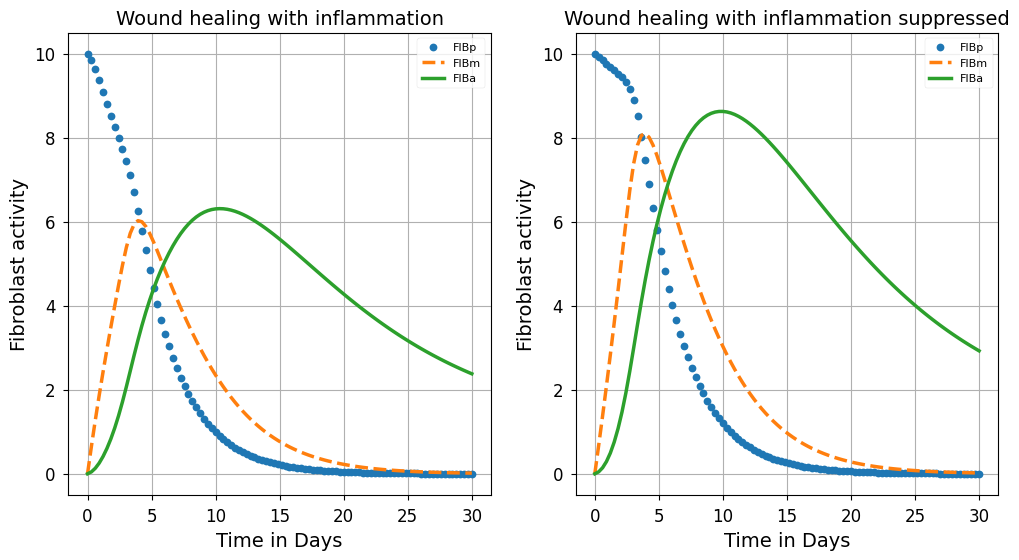

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12,6)) #plots 2 subplots
#slicing result 1 (an array) to plot activity of fbroblast cells
axs[0].plot(t, result1[:, 0],  'o', linewidth=2.5, label="FIBp")
axs[0].plot(t, result1[:, 1], '--', linewidth=2.5, label="FIBm")
axs[0].plot(t, result1[:, 2], linewidth=2.5, label="FIBa")
axs[0].set_title('Wound healing with inflammation', size='14') #setting title of the plot
axs[0].set_xlabel('Time in Days',size='14') #labelling x axis
axs[0].set_ylabel('Fibroblast activity',size='14') #labelling y axis
axs[0].tick_params(axis='both', labelsize=12) #increasing size of numbers in x and y axis

#setting similar features for the second plot
axs[1].plot(t, result2[:, 0], 'o', linewidth=2.5, label="FIBp")
axs[1].plot(t, result2[:, 1], '--', linewidth=2.5, label="FIBm")
axs[1].plot(t, result2[:, 2], linewidth=2.5, label="FIBa")
axs[1].set_title('Wound healing with inflammation suppressed',  size='14')
axs[1].set_xlabel('Time in Days',size='14')
axs[1].set_ylabel('Fibroblast activity',size='14')
axs[1].tick_params(axis='both', labelsize=12)
for ax in axs.flat:
    ax.grid() #setting grids for both plots
    ax.legend() #setting legend in both plots

# Collagen and Pathogens in a normal wound Healing process

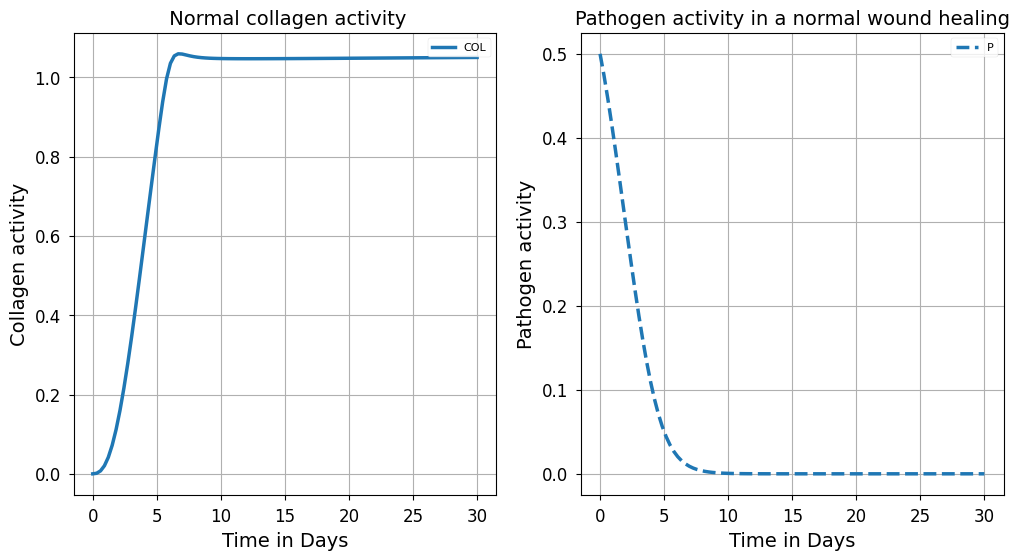

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(t, result1[:, 3], linewidth=2.5, label="COL")
axs[0].set(xlabel='Time in Days', ylabel='Collagen')
axs[0].tick_params(axis='both',labelsize=12)
axs[0].set_xlabel('Time in Days',size='14')
axs[0].set_ylabel('Collagen activity',size='14')
axs[0].set_title(' Normal collagen activity', size='14')
axs[1].plot(t, result1[:, 5], '--', linewidth=2.5, label="P")
axs[1].set(xlabel='Time in Days', ylabel='Pathogens')
axs[1].tick_params(axis='both',labelsize=12)
axs[1].set_title('Pathogen activity in a normal wound healing', size='14')
axs[1].set_xlabel('Time in Days',size='14')
axs[1].set_ylabel('Pathogen activity',size='14')
for ax in axs.flat:
    ax.grid()
    ax.legend()

#Inflammation in a normal wound healing

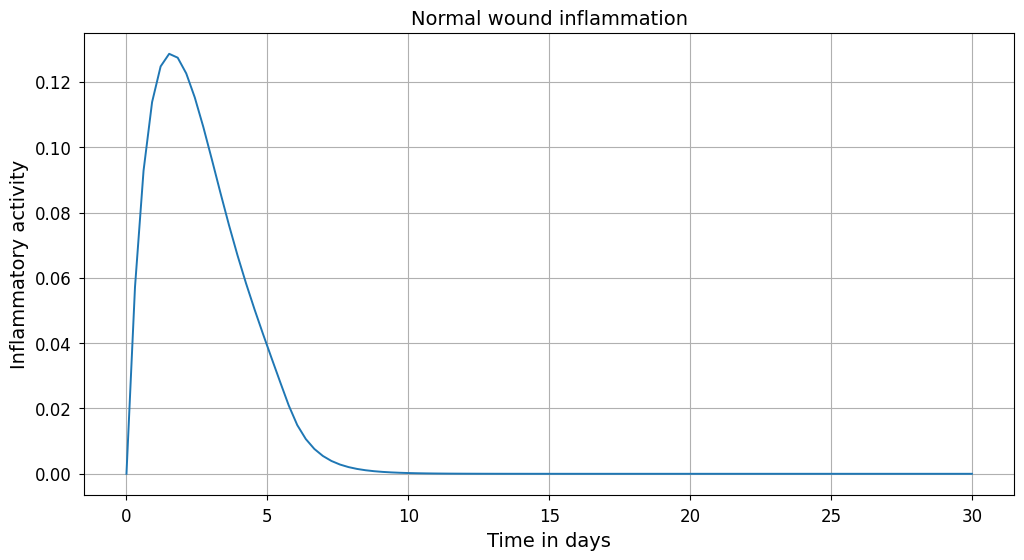

In [49]:
plt.figure(figsize=(12,6))
plt.plot(t , result1[:, 4])
plt.tick_params(axis='both',labelsize=12)
plt.xlabel('Time in days', size='14')
plt.ylabel('Inflammatory activity', size='14' )
plt.title('Normal wound inflammation', size='14') # title for inflammation under normal wound healing conditions
#plt.title('Inflammation in unclean wounds', size='14') #title for inflammation under increased pathogen activity
#plt.title('Inflammation under systematic factors', size='14') #title for inflammation under sysytematic factors
plt.grid()
plt.show()

# Effect of less Oxygen on Fibroblast cells

In [50]:
class ParabolicSystem2(tf.keras.Model):

  def call(self, t, v):
    μ_fib=0.1; p_fibm=0.6; p_fibp=0.4; p_fiba=0.3;d_f=0.3;
    k_fnm=0.5; k_fnp=0.4; k_fna=0.3; x_fn=0.6; p_bl=0.08; x_cf=4.2; h_fc=1; k_cf=1;
    k_cn=2; k_cfr=500; x_cfr=5; N_crit=0.01; k_np=0.5;k_nn=3; k_nw=2;
    s_nr=2; μ_nr=2.88; k_nf=0.1; μ_n=1.2; n_infty=0.6; c_infty=0.5; h_c=4; c_f_infty=0.8;c_fr_infty=1.8;
    F_infty=6; P_infty=20*(10**6); k_pgO=0.55; β_p=0.3; O_crit=25; k_pm=0.6; s_m=0.12; μ_m=0.048;
    k_mp=0.108; k_pn=0.2; w_sg=0.6; O_2=12; T_0=37; T=40; WS_0=0.6

    def Oxy(O_2):
      if O_2 >= O_crit:
        return k_pgO
      elif O_2 < O_crit:
        return k_pgO + β_p*(1-(O_2/O_crit))

    FIBp, FIBm, FIBa, COL, N, P = tf.unstack(v)
    f_ip= (FIBp/(1+(N+n_infty)**2)) ; f_c =(1/(1+(COL/c_infty)**4))
    f_im= (FIBm/(1+(N+n_infty)**2))
    f_ia= (FIBa/(1+(N+n_infty)**2))
    f_col= (1/(1+(COL/c_f_infty)**h_fc))
    f_co=(1-(1/(1+(COL/c_fr_infty)**(12))))
    s_h = (1/(1+(np.e)**((-50)*(N_crit-N))))
    g_O2=(1-(1.1/(1+(0.1)*(np.e)**((-0.3)*(O_2-O_crit)))))
    WS=max((1-COL)*WS_0*(1/(1-w_sg*g_O2)), 0)
    R_i= ((k_np*P+k_nn*N**3+k_nw*WS)/(1+((FIBp+FIBm+FIBa)/F_infty)**2))
    Q_i= (N/(1+(FIBa/F_infty)**2))

    dFIBpdt= -μ_fib*FIBp + p_fibp*f_ip*f_c-d_f*f_ip-k_fnp*(N/(x_fn+N))*FIBp
    dFIBmdt=-μ_fib*FIBm + p_fibm*f_im*f_c-d_f*f_im + d_f*f_ip-k_fnm*(N/(x_fn+N))*FIBm
    dFIBadt=-μ_fib*FIBa + p_fiba*f_ia*f_c+ d_f*f_im-k_fna*(N/(x_fn+N))*FIBa+p_bl
    dCOLdt= k_cf*(FIBa/(x_cf+FIBa))*f_col-k_cn*N*COL*np.e**(-(T-T_0)**2)-k_cfr*(FIBa/(x_cfr+FIBa))*s_h*f_co
    dNdt= ((s_nr*R_i)/(μ_nr+R_i))-k_nf*FIBa*N*np.e**(-(T-T_0)**2)-μ_n*N
    dPdt= Oxy(O_2) *P*(1-(P/P_infty))-((k_pm*s_m*P)/(μ_m+k_mp*P))-k_pn*P*Q_i*(1-g_O2)

    return tf.stack ([dFIBpdt, dFIBmdt, dFIBadt, dCOLdt,dNdt, dPdt])

initial_states = tf.convert_to_tensor([10., 0., 0., 0., 0., 0.5], dtype=tf.float64)

In [51]:
%%time

with tf.device(device):
  result3= odeint(ParabolicSystem2(), initial_states, t)

print("Finished integrating ! Result shape : ", result3.shape)

Finished integrating ! Result shape :  (100, 6)
CPU times: user 6.47 s, sys: 34.6 ms, total: 6.5 s
Wall time: 8.85 s


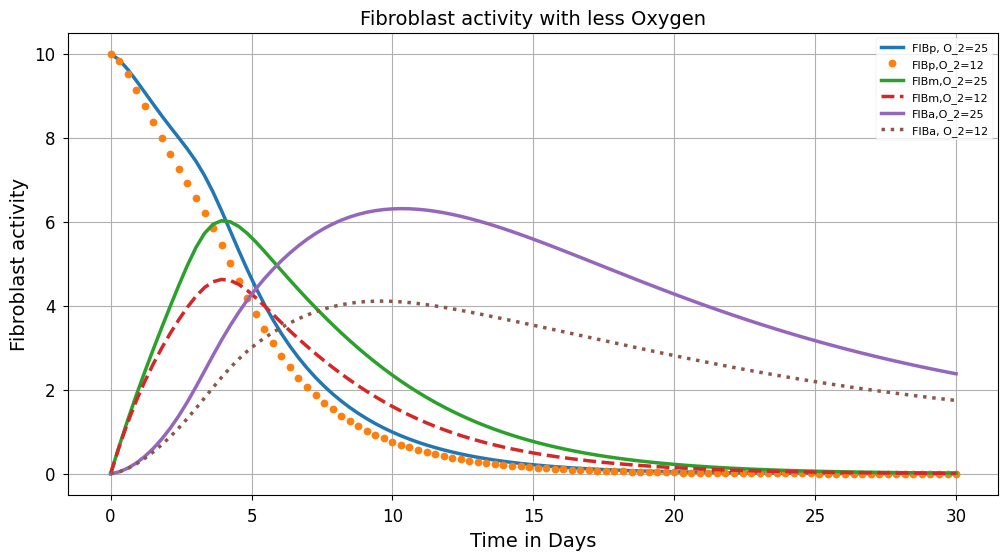

In [52]:
#a plot to show fibroblast activities in an acute wound
fig, axs = plt.subplots(1, 1, figsize=(12,6))
axs.plot(t, result1[:, 0], linewidth=2.5, label="FIBp, O_2=25")
axs.plot(t, result3[:, 0],  'o', linewidth=2.5, label="FIBp,O_2=12")
axs.plot(t, result1[:, 1], linewidth=2.5, label="FIBm,O_2=25")
axs.plot(t, result3[:, 1], '--', linewidth=2.5, label="FIBm,O_2=12")
axs.plot(t, result1[:, 2], linewidth=2.5, label="FIBa,O_2=25")
axs.plot(t, result3[:, 2], ':',linewidth=2.5, label="FIBa, O_2=12")
axs.set_xlabel('Time in Days',size='14')
axs.set_ylabel('Fibroblast activity',size='14')
axs.tick_params(axis='both', labelsize=12)
plt.title('Fibroblast activity with less Oxygen', size='14')
#plt.title('Fibroblast activity in unclean wound', size='14') #title for increased pathogen activity
#plt.title('Fibroblast activity under systematic factors', size='14') #title under systematic factors
axs.grid()
plt.legend()

# Effect of less Oxygen on Collagen and Pathogen activity

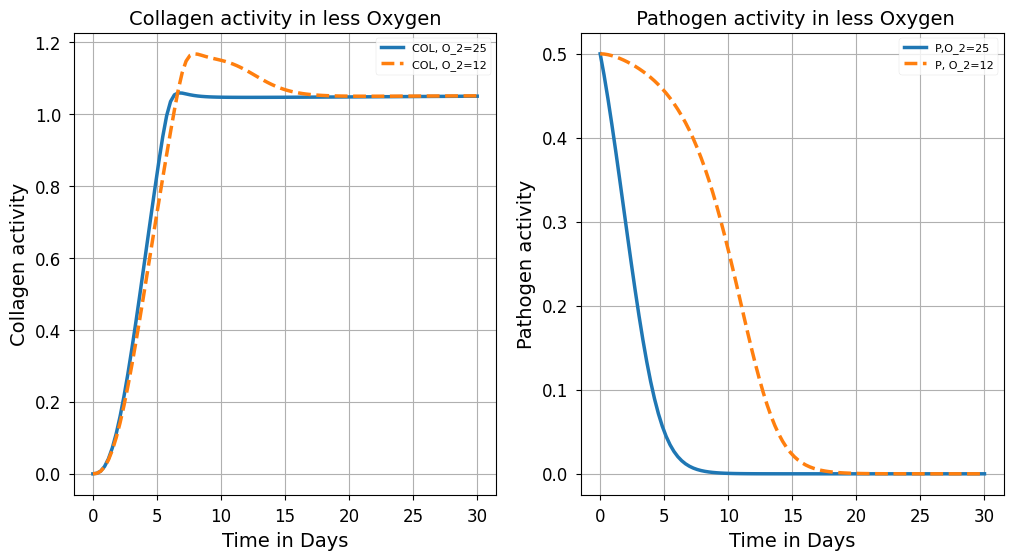

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(t, result1[:, 3], linewidth=2.5, label="COL, O_2=25")
axs[0].plot(t, result3[:, 3], '--', linewidth=2.5, label="COL, O_2=12")
axs[0].set(xlabel='Time in Days', ylabel='Collagen')
axs[0].tick_params(axis='both',labelsize=12)
axs[0].set_xlabel('Time in Days',size='14')
axs[0].set_ylabel('Collagen activity',size='14')
#axs[0].set_title('Collagen activity', size='14')
axs[0].set_title('Collagen activity in less Oxygen', size='14')
#axs[0].set_title('Collagen activity in an unclean wound', size='14')
#axs[0].set_title('Collagen activity under systematic factors', size='14')
axs[1].plot(t, result1[:, 5], linewidth=2.5, label="P,O_2=25")
axs[1].plot(t, result3[:, 5], '--', linewidth=2.5, label="P, O_2=12")
axs[1].set(xlabel='Time in Days', ylabel='Pathogens')
axs[1].tick_params(axis='both',labelsize=12)
#axs[1].set_title(' Pathogen activity', size='14')
axs[1].set_title(' Pathogen activity in less Oxygen', size='14')
#axs[1].set_title(' Pathogen activity in an unclean wound', size='14')
#axs[1].set_title(' Pathogen activity in under systematic factors', size='14')
axs[1].set_xlabel('Time in Days',size='14')
axs[1].set_ylabel('Pathogen activity',size='14')
for ax in axs.flat:
    ax.grid()
    ax.legend()

# Inflammation in less oxygenated wounds

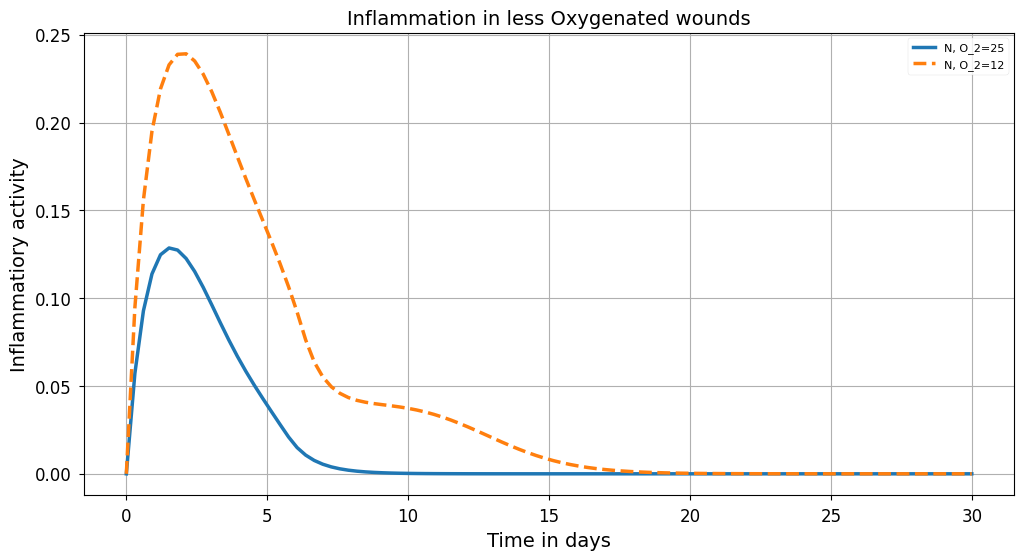

In [54]:
plt.figure(figsize=(12,6))
plt.plot(t , result1[:, 4], linewidth=2.5, label="N, O_2=25")
plt.plot(t , result3[:, 4], '--', linewidth=2.5, label="N, O_2=12")
plt.tick_params(axis='both',labelsize=12)
plt.xlabel('Time in days', size='14')
plt.ylabel('Inflammatiory activity', size='14' )
#plt.title('Normal wound inflammation', size='14') # title for inflammation under normal wound healing conditions
plt.title('Inflammation in less Oxygenated wounds', size='14') #title for inflammation in less oxygenated wounds
#plt.title('Inflammation in unclean wounds', size='14') #title for inflammation under increased pathogen activity
#plt.title('Inflammation under systematic factors', size='14') #title for inflammation under sysytematic factors
plt.grid()
plt.legend()
plt.show()

# Fibloblast activity in unclean wounds


In [55]:
class ParabolicSystem3(tf.keras.Model):

  def call(self, t, v):

    WS_0=0.6
    FIBp, FIBm, FIBa, COL, N, P = tf.unstack(v)
    f_ip= (FIBp/(1+(N+n_infty)**2)) ; f_c =(1/(1+(COL/c_infty)**4))
    f_im= (FIBm/(1+(N+n_infty)**2))
    f_ia= (FIBa/(1+(N+n_infty)**2))
    f_col= (1/(1+(COL/c_f_infty)**h_fc))
    f_co=(1-(1/(1+(COL/c_fr_infty)**(12))))
    s_h = (1/(1+(np.e)**((-50)*(N_crit-N))))
    g_O2=(1-(1.1/(1+(0.1)*(np.e)**((-0.3)*(O_2-O_crit)))))
    WS=max((1-COL)*WS_0*(1/(1-w_sg*g_O2)), 0)
    R_i= ((k_np*P+k_nn*N**3+k_nw*WS)/(1+((FIBp+FIBm+FIBa)/F_infty)**2))
    Q_i= (N/(1+(FIBa/F_infty)**2))

    dFIBpdt= -μ_fib*FIBp + p_fibp*f_ip*f_c-d_f*f_ip-k_fnp*(N/(x_fn+N))*FIBp
    dFIBmdt=-μ_fib*FIBm + p_fibm*f_im*f_c-d_f*f_im + d_f*f_ip-k_fnm*(N/(x_fn+N))*FIBm
    dFIBadt=-μ_fib*FIBa + p_fiba*f_ia*f_c+ d_f*f_im-k_fna*(N/(x_fn+N))*FIBa+p_bl
    dCOLdt= k_cf*(FIBa/(x_cf+FIBa))*f_col-k_cn*N*COL*np.e**(-(T-T_0)**2)-k_cfr*(FIBa/(x_cfr+FIBa))*s_h*f_co
    dNdt= ((s_nr*R_i)/(μ_nr+R_i))-k_nf*FIBa*N*np.e**(-(T-T_0)**2)-μ_n*N
    dPdt= Oxy(O_2) *P*(1-(P/P_infty))-((k_pm*s_m*P)/(μ_m+k_mp*P))-k_pn*P*Q_i*(1-g_O2)

    return tf.stack ([dFIBpdt, dFIBmdt, dFIBadt, dCOLdt,  dNdt, dPdt])


initial_states = tf.convert_to_tensor([10., 0., 0., 0., 0., 0.8], dtype=tf.float64)

In [56]:
%%time

with tf.device(device):
  result4 = odeint(ParabolicSystem3(), initial_states, t)

print("Finished integrating ! Result shape : ", result4.shape)

Finished integrating ! Result shape :  (100, 6)
CPU times: user 9.17 s, sys: 38.1 ms, total: 9.21 s
Wall time: 19.4 s


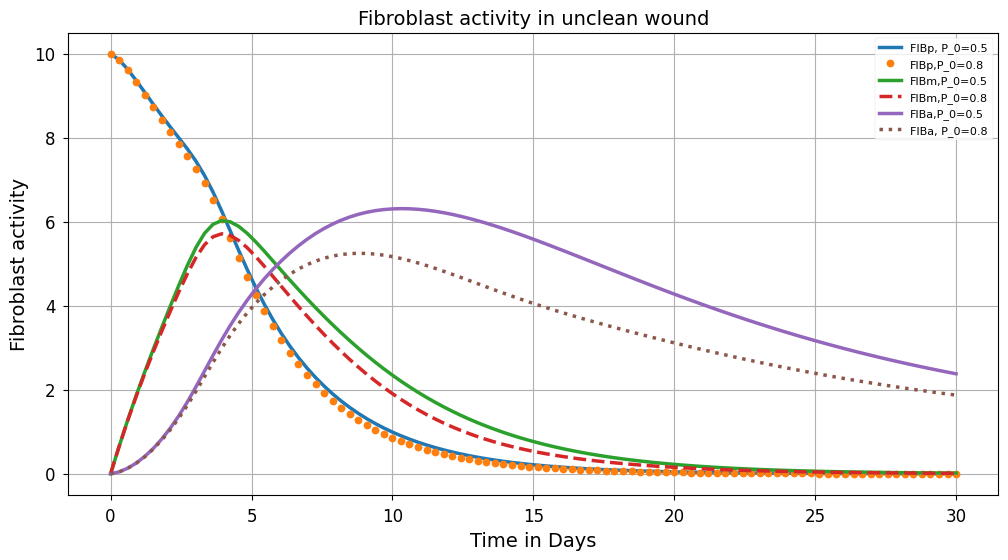

In [57]:
#a plot to show fibroblast activities in an acute wound
fig, axs = plt.subplots(1, 1, figsize=(12,6))
axs.plot(t, result1[:, 0], linewidth=2.5, label="FIBp, P_0=0.5")
axs.plot(t, result4[:, 0],  'o', linewidth=2.5, label="FIBp,P_0=0.8")
axs.plot(t, result1[:, 1], linewidth=2.5, label="FIBm,P_0=0.5")
axs.plot(t, result4[:, 1], '--', linewidth=2.5, label="FIBm,P_0=0.8")
axs.plot(t, result1[:, 2], linewidth=2.5, label="FIBa,P_0=0.5")
axs.plot(t, result4[:, 2], ':',linewidth=2.5, label="FIBa, P_0=0.8")
axs.set_xlabel('Time in Days',size='14')
axs.set_ylabel('Fibroblast activity',size='14')
axs.tick_params(axis='both', labelsize=12)
plt.title('Fibroblast activity in unclean wound', size='14') #title for increased pathogen activity
#plt.title('Fibroblast activity under systematic factors', size='14') #title under systematic factors
axs.grid()
plt.legend()

# Collagen and Pathogen activity in unclean wounds

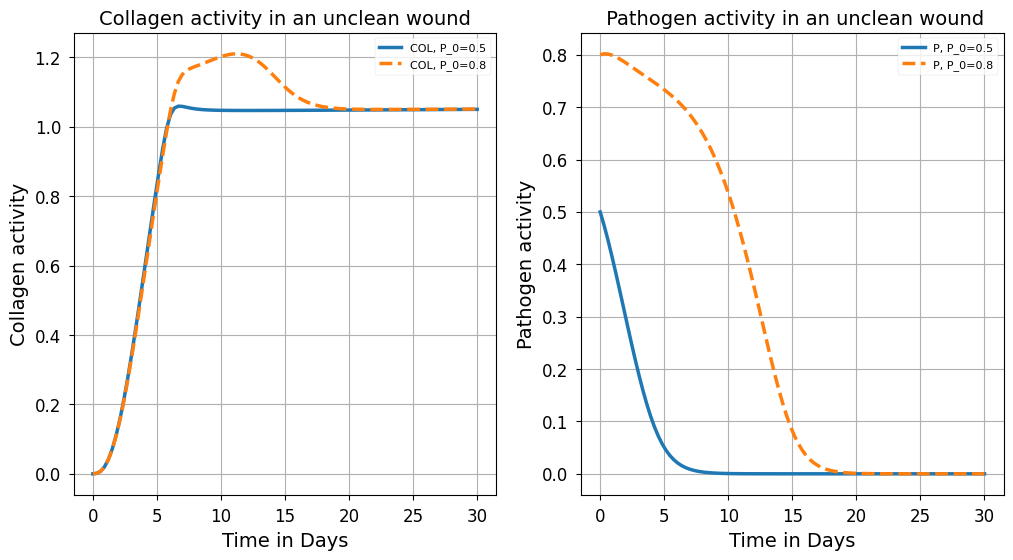

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(t, result1[:, 3], linewidth=2.5, label="COL, P_0=0.5")
axs[0].plot(t, result4[:, 3], '--', linewidth=2.5, label="COL, P_0=0.8")
axs[0].set(xlabel='Time in Days', ylabel='Collagen')
axs[0].tick_params(axis='both',labelsize=12)
axs[0].set_xlabel('Time in Days',size='14')
axs[0].set_ylabel('Collagen activity',size='14')
axs[0].set_title('Collagen activity in an unclean wound', size='14')
axs[1].plot(t, result1[:, 5], linewidth=2.5, label="P, P_0=0.5")
axs[1].plot(t, result4[:, 5], '--', linewidth=2.5, label="P, P_0=0.8")
axs[1].set(xlabel='Time in Days', ylabel='Pathogen activity')
axs[1].tick_params(axis='both',labelsize=12)
axs[1].set_title(' Pathogen activity in an unclean wound', size='14')
axs[1].set_xlabel('Time in Days',size='14')
axs[1].set_ylabel('Pathogen activity',size='14')
for ax in axs.flat:
    ax.grid()
    ax.legend()

# Inflammation in unclean wounds

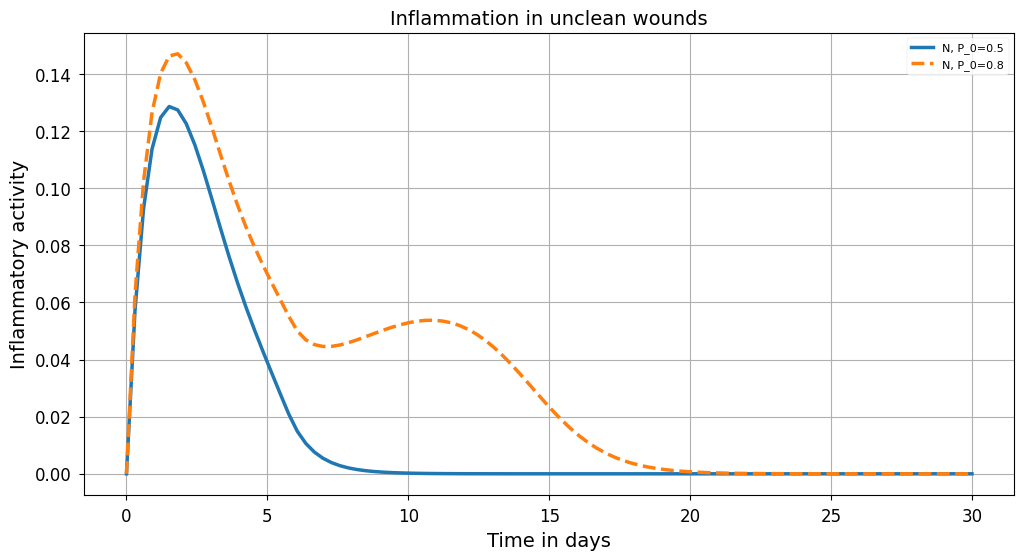

In [59]:
plt.figure(figsize=(12,6))
plt.plot(t , result1[:, 4], linewidth=2.5, label="N, P_0=0.5")
plt.plot(t , result4[:, 4], '--', linewidth=2.5, label="N, P_0=0.8")
plt.tick_params(axis='both',labelsize=12)
plt.xlabel('Time in days', size='14')
plt.ylabel('Inflammatory activity', size='14' )
plt.title('Inflammation in unclean wounds', size='14') #title for inflammation under increased pathogen activity
plt.grid()
plt.legend()
plt.show()

# A Chronic wound

In [60]:
class ParabolicSystem4(tf.keras.Model):

  def call(self, t, v):

    WS_0=0.8; #initial wound size 0.8 for a chronic wound
    FIBp, FIBm, FIBa, COL, N, P = tf.unstack(v)
    f_ip= (FIBp/(1+(N+n_infty)**2)) ; f_c =(1/(1+(COL/c_infty)**4))
    f_im= (FIBm/(1+(N+n_infty)**2))
    f_ia= (FIBa/(1+(N+n_infty)**2))
    f_col= (1/(1+(COL/c_f_infty)**h_fc))
    f_co=(1-(1/(1+(COL/c_fr_infty)**(12))))
    s_h = (1/(1+(np.e)**((-50)*(N_crit-N))))
    g_O2=(1-(1.1/(1+(0.1)*(np.e)**((-0.3)*(O_2-O_crit)))))
    WS=max((1-COL)*WS_0*(1/(1-w_sg*g_O2)), 0)
    R_i= ((k_np*P+k_nn*N**3+k_nw*WS)/(1+((FIBp)/F_infty)**2))
    #R_i= ((k_np*P+k_nn*N**3+k_nw*WS)/(1+((FIBp+FIBm+FIBa)/F_infty)**2))
    Q_i= (N/(1+(FIBa/F_infty)**2))

    dFIBpdt= -μ_fib*FIBp + p_fibp*f_ip*f_c-d_f*f_ip-k_fnp*(N/(x_fn+N))*FIBp
    dFIBmdt=-μ_fib*FIBm + p_fibm*f_im*f_c-d_f*f_im + d_f*f_ip-k_fnm*(N/(x_fn+N))*FIBm
    dFIBadt=-μ_fib*FIBa + p_fiba*f_ia*f_c+ d_f*f_im-k_fna*(N/(x_fn+N))*FIBa+p_bl
    dCOLdt= k_cf*(FIBa/(x_cf+FIBa))*f_col-k_cn*N*COL*np.e**(-(T-T_0)**2)-k_cfr*(FIBa/(x_cfr+FIBa))*s_h*f_co
    dNdt= ((s_nr*R_i)/(μ_nr+R_i))-k_nf*FIBa*N*np.e**(-(T-T_0)**2)-μ_n*N
    dPdt= Oxy(O_2) *P*(1-(P/P_infty))-((k_pm*s_m*P)/(μ_m+k_mp*P))-k_pn*P*Q_i*(1-g_O2)

    return tf.stack ([dFIBpdt, dFIBmdt, dFIBadt, dCOLdt,  dNdt, dPdt])


initial_states = tf.convert_to_tensor([7., 0., 0., 0., 0., 0.6], dtype=tf.float64)




In [61]:
%%time

with tf.device(device):
  result5 = odeint(ParabolicSystem4(), initial_states, t)

print("Finished integrating ! Result shape : ", result5.shape)

Finished integrating ! Result shape :  (100, 6)
CPU times: user 4.03 s, sys: 18.5 ms, total: 4.05 s
Wall time: 4.07 s


# Cell activities in an acute and chronic wounds

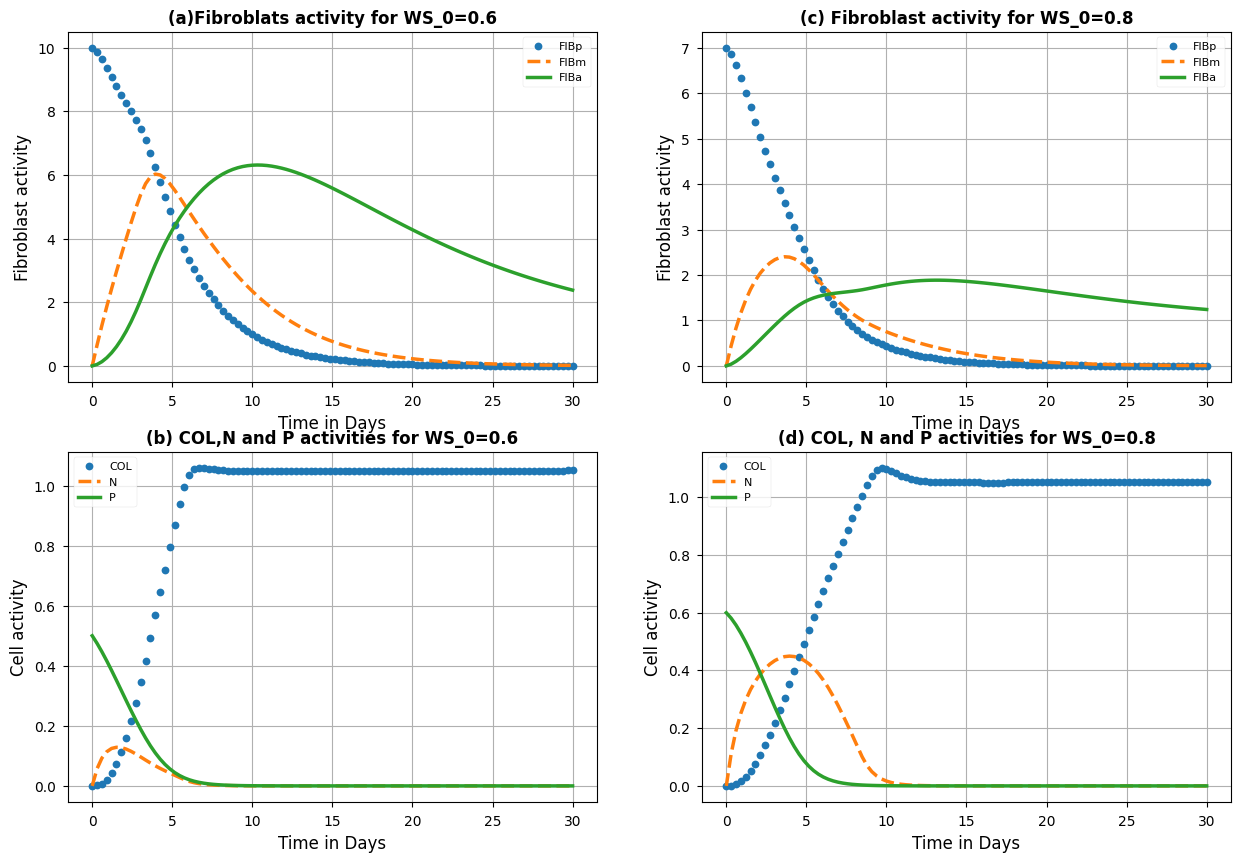

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

axs[0,0].plot(t, result1[:, 0],  'o', linewidth=2.5, label="FIBp")
axs[0,0].plot(t, result1[:, 1], '--', linewidth=2.5, label="FIBm")
axs[0,0].plot(t, result1[:, 2], linewidth=2.5, label="FIBa")
axs[0,0].set_title('(a)Fibroblats activity for WS_0=0.6', fontweight='bold', size='12')
axs[0,0].set_xlabel('Time in Days',size='12')
axs[0,0].set_ylabel('Fibroblast activity',size='12')
axs[0,0].tick_params(axis='both',labelsize=10)


axs[0,1].plot(t, result5[:, 0], 'o', linewidth=2.5, label="FIBp")
axs[0,1].plot(t, result5[:, 1], '--', linewidth=2.5, label="FIBm")
axs[0,1].plot(t, result5[:, 2], linewidth=2.5, label="FIBa")
axs[0,1].set_title('(c) Fibroblast activity for WS_0=0.8', fontweight='bold', size='12')
axs[0,1].set_xlabel('Time in Days',size='12')
axs[0,1].set_ylabel('Fibroblast activity',size='12')
axs[0,1].tick_params(axis='both',labelsize=10)

axs[1,0].plot(t, result1[:, 3], 'o', linewidth=2.5, label="COL")
axs[1,0].plot(t, result1[:, 4], '--', linewidth=2.5, label="N")
axs[1,0].plot(t, result1[:, 5], linewidth=2.5, label="P")
axs[1,0].set_title('(b) COL,N and P activities for WS_0=0.6', fontweight='bold', size='12')
axs[1,0].set_xlabel('Time in Days',size='12')
axs[1,0].set_ylabel('Cell activity',size='12')
axs[1,0].tick_params(axis='both',labelsize=10)

axs[1,1].plot(t, result5[:, 3], 'o', linewidth=2.5, label="COL")
axs[1,1].plot(t, result5[:, 4], '--', linewidth=2.5, label="N")
axs[1,1].plot(t, result5[:, 5], linewidth=2.5, label="P")
axs[1,1].set_title('(d) COL, N and P activities for WS_0=0.8', fontweight='bold', size='12')
axs[1,1].set_xlabel('Time in Days',size='12')
axs[1,1].set_ylabel('Cell activity',size='12')
axs[1,1].tick_params(axis='both',labelsize=10)

for ax in axs.flat:
    ax.grid()
    ax.legend()


# Effects of Systematic factors on cell activities


In [63]:
class ParabolicSystem5(tf.keras.Model):

  def call(self, t, v):
    μ_fib=0.1; p_fibm=0.6; p_fibp=0.4; p_fiba=0.3;d_f=0.3;
    k_fnm=0.5; k_fnp=0.4; k_fna=0.3; x_fn=0.6; p_bl=0.08; x_cf=4.2; h_fc=1; k_cf=1;
    k_cn=2; k_cfr=500; x_cfr=5; N_crit=0.01; k_np=0.5;k_nn=3; k_nw=2; μ_nr=2.88;
    k_nf=0.1; μ_n=1.2; n_infty=0.6; c_infty=0.5; h_c=4; c_f_infty=0.8;c_fr_infty=1.8;
    F_infty=6; P_infty=20*(10**6); k_pgO=0.55; β_p=0.3; O_crit=25; k_pm=0.6; s_m=0.12; μ_m=0.048;
    k_mp=0.108; k_pn=0.2; w_sg=0.6; O_2=12; T_0=37; T=40; s_nr=1.2; WS_0=0.6

    def Oxy(O_2):
      if O_2 >= O_crit:
        return k_pgO
      elif O_2 < O_crit:
        return k_pgO + β_p*(1-(O_2/O_crit))

    FIBp, FIBm, FIBa, COL, N, P = tf.unstack(v)
    f_ip= (FIBp/(1+(N+n_infty)**2)) ; f_c =(1/(1+(COL/c_infty)**4))
    f_im= (FIBm/(1+(N+n_infty)**2))
    f_ia= (FIBa/(1+(N+n_infty)**2))
    f_col= (1/(1+(COL/c_f_infty)**h_fc))
    f_co=(1-(1/(1+(COL/c_fr_infty)**(12))))
    s_h = (1/(1+(np.e)**((-50)*(N_crit-N))))
    g_O2=(1-(1.1/(1+(0.1)*(np.e)**((-0.3)*(O_2-O_crit)))))
    WS=max((1-COL)*WS_0*(1/(1-w_sg*g_O2)), 0)
    R_i= ((k_np*P+k_nn*N**3+k_nw*WS)/(1+((FIBp+FIBm+FIBa)/F_infty)**2))
    Q_i= (N/(1+(FIBa/F_infty)**2))

    dFIBpdt= -μ_fib*FIBp + p_fibp*f_ip*f_c-d_f*f_ip-k_fnp*(N/(x_fn+N))*FIBp
    dFIBmdt=-μ_fib*FIBm + p_fibm*f_im*f_c-d_f*f_im + d_f*f_ip-k_fnm*(N/(x_fn+N))*FIBm
    dFIBadt=-μ_fib*FIBa + p_fiba*f_ia*f_c+d_f*f_im-k_fna*(N/(x_fn+N))*FIBa+p_bl
    dCOLdt= k_cf*(FIBa/(x_cf+FIBa))*f_col-k_cn*N*COL*np.e**(-(T-T_0)**2)-k_cfr*(FIBa/(x_cfr+FIBa))*s_h*f_co
    dNdt= ((s_nr*R_i)/(μ_nr+R_i))-k_nf*FIBa*N*np.e**(-(T-T_0)**2)-μ_n*N
    dPdt= Oxy(O_2) *P*(1-(P/P_infty))-((k_pm*s_m*P)/(μ_m+k_mp*P))-k_pn*P*Q_i*(1-g_O2)

    return tf.stack ([dFIBpdt, dFIBmdt, dFIBadt, dCOLdt,dNdt, dPdt])

initial_states = tf.convert_to_tensor([8., 0., 0., 0., 0., 0.5], dtype=tf.float64)

In [64]:
%%time

with tf.device(device):
  result6 = odeint(ParabolicSystem5(), initial_states, t)

print("Finished integrating ! Result shape : ", result6.shape)

Finished integrating ! Result shape :  (100, 6)
CPU times: user 4.75 s, sys: 20.2 ms, total: 4.77 s
Wall time: 4.83 s


# Fibroblasts activity under systematic factors

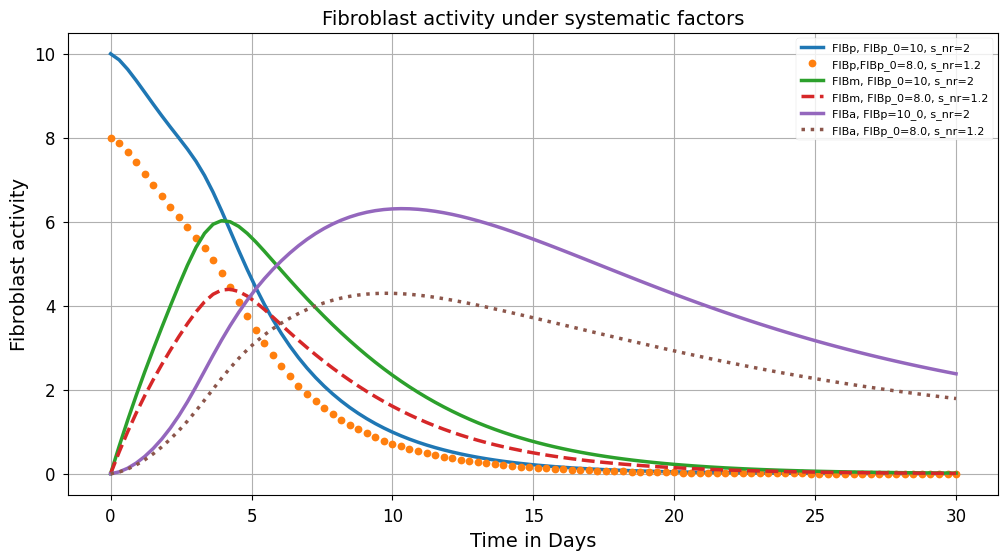

In [65]:
#a plot to show fibroblast activities in an acute wound
fig, axs = plt.subplots(1, 1, figsize=(12,6))
axs.plot(t, result1[:, 0], linewidth=2.5, label="FIBp, FIBp_0=10, s_nr=2")
axs.plot(t, result6[:, 0],  'o', linewidth=2.5, label="FIBp,FIBp_0=8.0, s_nr=1.2")
axs.plot(t, result1[:, 1], linewidth=2.5, label="FIBm, FIBp_0=10, s_nr=2")
axs.plot(t, result6[:, 1], '--', linewidth=2.5, label="FIBm, FIBp_0=8.0, s_nr=1.2")
axs.plot(t, result1[:, 2], linewidth=2.5, label="FIBa, FIBp=10_0, s_nr=2")
axs.plot(t, result6[:, 2], ':',linewidth=2.5, label="FIBa, FIBp_0=8.0, s_nr=1.2")
axs.set_xlabel('Time in Days',size='14')
axs.set_ylabel('Fibroblast activity',size='14')
axs.tick_params(axis='both', labelsize=12)
plt.title('Fibroblast activity under systematic factors', size='14') #title under systematic factors
axs.grid()
plt.legend()

# Collagen and Pathogen activity under systematic factors


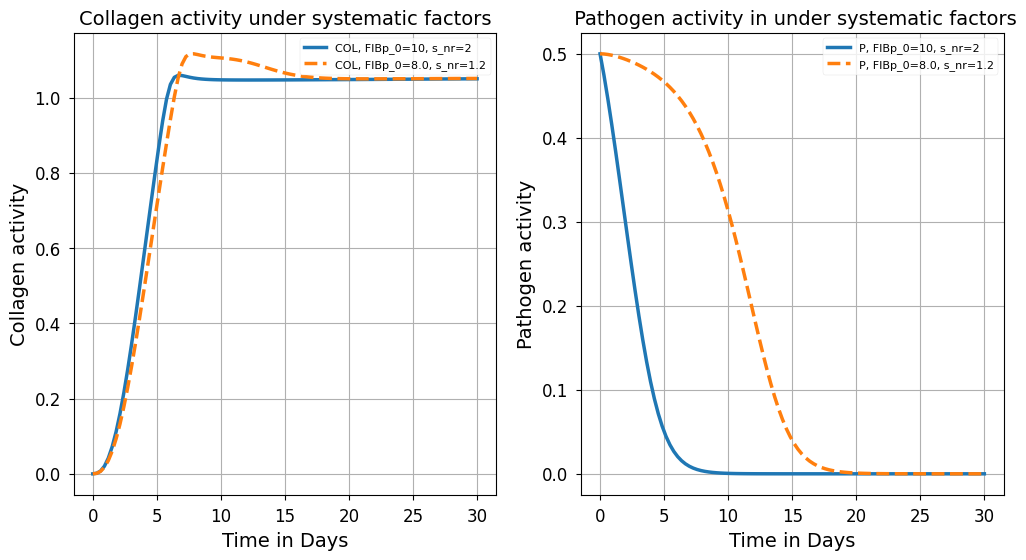

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(t, result1[:, 3], linewidth=2.5, label="COL, FIBp_0=10, s_nr=2")
axs[0].plot(t, result6[:, 3], '--', linewidth=2.5, label="COL, FIBp_0=8.0, s_nr=1.2")
axs[0].set(xlabel='Time in Days', ylabel='Collagen')
axs[0].tick_params(axis='both',labelsize=12)
axs[0].set_xlabel('Time in Days',size='14')
axs[0].set_ylabel('Collagen activity',size='14')
axs[0].set_title('Collagen activity under systematic factors', size='14')
axs[1].plot(t, result1[:, 5], linewidth=2.5, label="P, FIBp_0=10, s_nr=2")
axs[1].plot(t, result6[:, 5], '--', linewidth=2.5, label="P, FIBp_0=8.0, s_nr=1.2")
axs[1].set(xlabel='Time in Days', ylabel='Pathogen activity')
axs[1].tick_params(axis='both',labelsize=12)
axs[1].set_title(' Pathogen activity in under systematic factors', size='14')
axs[1].set_xlabel('Time in Days',size='14')
axs[1].set_ylabel('Pathogen activity',size='14')
for ax in axs.flat:
    ax.grid()
    ax.legend()

# Inflammation due to systematic factors

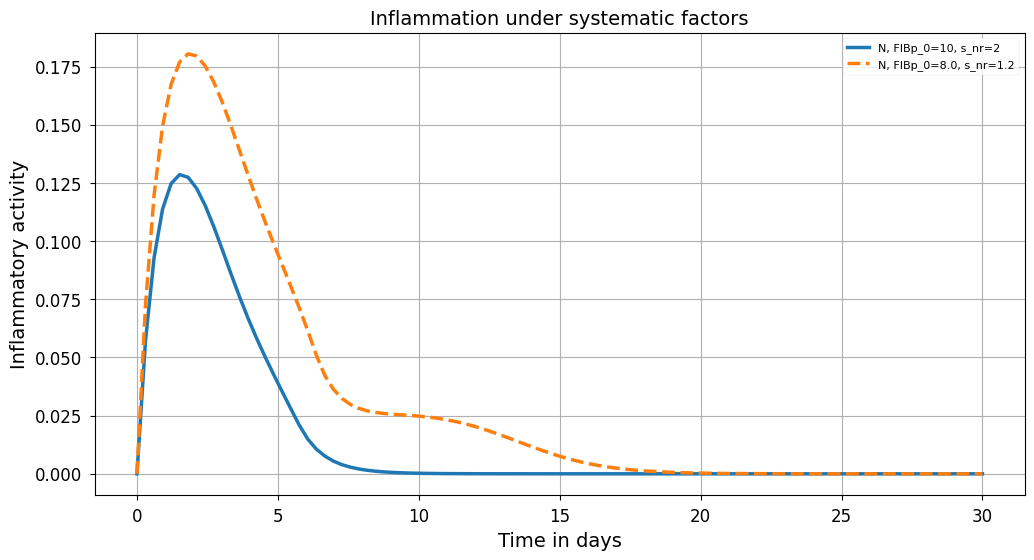

In [67]:
plt.figure(figsize=(12,6))
plt.plot(t , result1[:, 4], linewidth=2.5, label="N, FIBp_0=10, s_nr=2")
plt.plot(t , result6[:, 4], '--', linewidth=2.5, label="N, FIBp_0=8.0, s_nr=1.2")
plt.tick_params(axis='both',labelsize=12)
plt.xlabel('Time in days', size='14')
plt.ylabel('Inflammatory activity', size='14' )
plt.title('Inflammation under systematic factors', size='14')
plt.grid()
plt.legend()
plt.show()

# Temperature and Wound healing

In [68]:
COL=1.0; N=0.1; T_0=33; FIBa=5

T = np.linspace(25, 50, 50)
def f(T):
   return k_cn*N*COL*np.e**(-(T-T_0)**2)
def f1(T):
   return k_nf*FIBa*N*np.e**(-(T-T_0)**2)

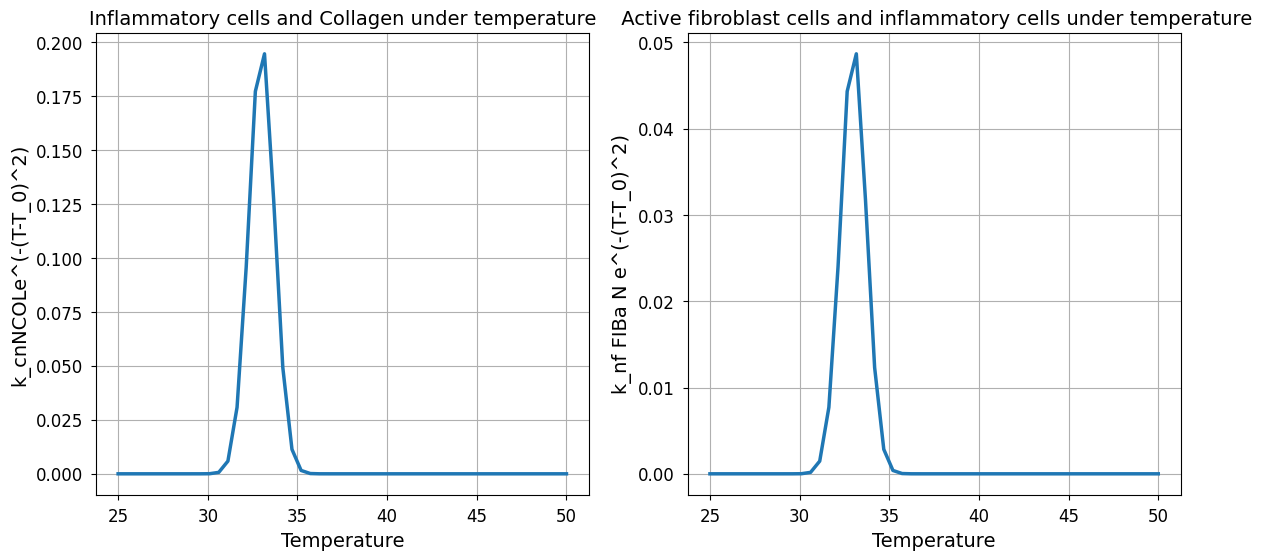

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].plot(T, f(T), linewidth=2.5)
axs[0].set(xlabel='Temperature', ylabel='')
axs[0].tick_params(axis='both',labelsize=12)
axs[0].set_xlabel('Temperature',size='14')
axs[0].set_ylabel('k_cnNCOLe^(-(T-T_0)^2)',size='14')
axs[0].set_title('Inflammatory cells and Collagen under temperature', size='14')
axs[1].plot(T, f1(T), linewidth=2.5)
axs[1].set(xlabel='Temperature', ylabel='')
axs[1].tick_params(axis='both',labelsize=12)
axs[1].set_title(' Active fibroblast cells and inflammatory cells under temperature', size='14')
axs[1].set_xlabel('Temperature',size='14')
axs[1].set_ylabel('k_nf FIBa N e^(-(T-T_0)^2)',size='14')
for ax in axs.flat:
    ax.grid()


# Impact of Oxygen levels on pathogen growth rate and decreased activity of inflammatory cells

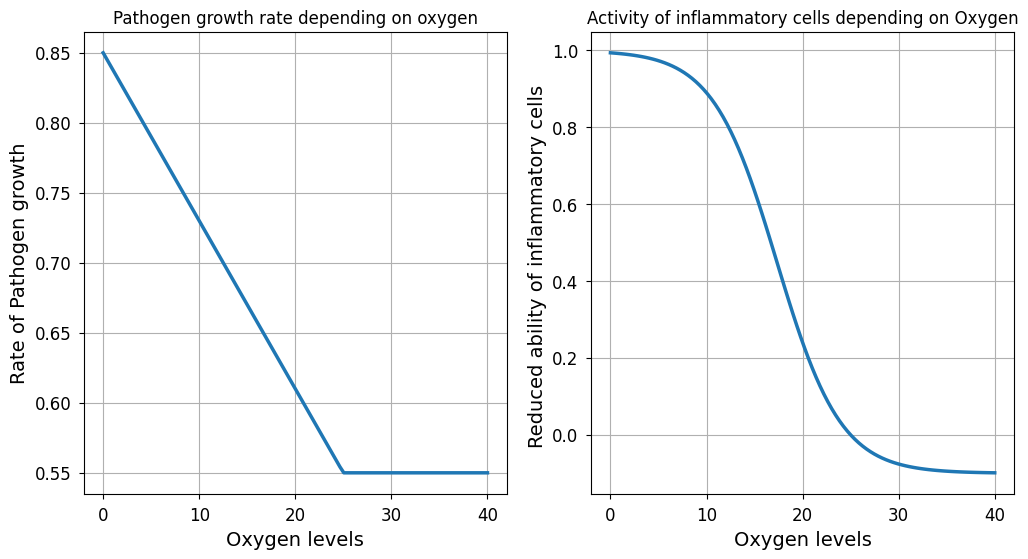

In [70]:
def Oxy(O_2):
  if O_2 >= O_crit:
    return k_pgO
  elif O_2 < O_crit:
    return k_pgO + β_p*(1-(O_2/O_crit))

O_2 = np.linspace(0., 40, 100)
y = []
for i in range(len(O_2)):
   y.append(Oxy(O_2[i]))
g_O2=(1-(1.1/(1+(0.1)*(np.e)**(-(0.3)*(O_2-O_crit)))))

fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(O_2, y,linewidth=2.5)
axs[0].set_title('Pathogen growth rate depending on oxygen', size='12')
axs[0].set_xlabel('Oxygen levels',size='14')
axs[0].set_ylabel('Rate of Pathogen growth',size='14')
axs[0].tick_params(axis='both',labelsize=12)
axs[1].plot(O_2, g_O2, linewidth=2.5)
axs[1].set_title('Activity of inflammatory cells depending on Oxygen', size='12')
axs[1].set_xlabel('Oxygen levels',size='14')
axs[1].set_ylabel('Reduced ability of inflammatory cells ',size='14')
axs[1].tick_params(axis='both',labelsize=12)
for ax in axs.flat:
    ax.grid()

